In [169]:
from functools import lru_cache
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

In [77]:
# ad-hoc imports
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.adjust_text import adjust_text

In [78]:
# load data (hack)
sys.path.append(os.path.abspath(os.path.join('..', 'data', 'robomission')))
from tasks_2017_09_25 import tasks

In [195]:
# helper functions

def get_letters(task):
    """Return all letters (= backgrounds and objects) in the setting of a task"""
    letters = set()
    fields = task.setting['fields']
    for row in fields:
        for background, objects in row:
            letters.add(background)
            letters.update(objects)
    return letters


def _get_all_letters():
    """Return set of all letters appearing in at least one task
    
    Ignores letters appearing in all tasks (they are not informative)
    """
    letter_sets = [get_letters(task) for task in tasks]
    letters_in_some_tasks = set.union(*letter_sets)
    letters_in_all_tasks = set.intersection(*letter_sets)
    return letters_in_some_tasks - letters_in_all_tasks

ALL_LETTERS = _get_all_letters()


def get_setting_features(task):
    letters = get_letters(task)
    features = {
        letter: int(letter in letters)
        for letter in ALL_LETTERS
    }
    return features


def _get_tokens(ast):
    """Return a set of all tokens (~ blockly blocks) in given RoboAST
    """
    # TODO: unhack, allow for and/or
    if not ast:
        return set()
    if 'statement' in ast:
        return _get_tokens(ast['statement'])
    tokens = {ast['head']}
    if 'test' in ast:
        tokens.add(ast['test']['head'])
    next_statements = ast['body'] if 'body' in ast else []
    if 'orelse' in ast and ast['orelse'] is not None:
        next_statements.append(ast['orelse'])
    for statement in next_statements:
        tokens.update(_get_tokens(statement))
    return tokens


def get_solution_tokens(task):
    return _get_tokens(task.solution)


def _get_all_solution_tokens():
    """Return set of all tokens appearing in at least one task
    
    Ignores tokens appearing in all tasks (they are not informative)
    """
    token_sets = [get_solution_tokens(task) for task in tasks]
    tokens_in_some_tasks = set.union(*token_sets)
    tokens_in_all_tasks = set.intersection(*token_sets)
    return tokens_in_some_tasks - tokens_in_all_tasks

ALL_TOKENS = _get_all_solution_tokens()


def get_solution_features(task):
    tokens = get_solution_tokens(task)
    features = {
        token: int(token in tokens)
        for token in ALL_TOKENS
    }
    return features


def get_features(task, setting=True, solution=True):
    """Compute features from the setting of a given task.
    
    Args:
        task: task for which to compute the features
        
    Returns:
        dict of features
    """
    features = {}
    if setting:
        features.update(get_setting_features(task))
    if solution:
        features.update(get_solution_features(task))
    return features


def get_level(task, norm=True):
    levels = {
        'moves': 1,
        'world': 2,
        'repeat': 3,
        'while': 4,
        'loops': 5,
        'if': 6,
        'comparing': 7,
        'if-else': 8,
        'final-challenge': 9
    }
    level = levels[task.category_id]
    return level/9 if norm else level


def get_color(task):
    cm = plt.get_cmap('viridis')
    colors = {
        'moves': cm.colors[0],
        'world': cm.colors[32],
        'repeat': cm.colors[32 * 2],
        'while': cm.colors[32 * 3],
        'loops': cm.colors[32 * 4],
        'if': cm.colors[32 * 5],
        'comparing': cm.colors[32 * 6],
        'if-else': cm.colors[32 * 7],
        'final-challenge': cm.colors[32 * 8 - 1]
    }
    return colors[task.category_id]

# info:
print('ALL_LETTERS:', ALL_LETTERS)
print('ALL_TOKENS:', ALL_TOKENS)

ALL_LETTERS: {'W', 'y', 'X', 'D', 'A', 'M', 'Y', 'Z', 'r'}
ALL_TOKENS: {'else', 'fly', 'while', 'position', 'color', 'if', 'shoot', 'repeat', 'right', 'left'}


In [155]:
setting_features = pd.DataFrame.from_records([get_setting_features(task) for task in tasks])
setting_features.head()

,A,D,M,W,X,Y,Z,r,y
0,1,0,0,0,0,0,0,0,1
1,1,1,1,1,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0


In [156]:
solution_features = pd.DataFrame.from_records([get_solution_features(task) for task in tasks])
solution_features.head()

,color,else,fly,if,left,position,repeat,right,shoot,while
0,1,0,1,0,1,0,0,0,0,1
1,0,0,1,0,1,0,1,1,1,0
2,1,0,1,1,0,1,0,1,0,1
3,1,0,1,0,0,0,0,0,1,1
4,1,1,0,1,1,1,0,1,0,1


In [167]:
all_features = pd.DataFrame.from_records([get_features(task) for task in tasks])
all_features.head()

,A,D,M,W,X,Y,Z,color,else,fly,if,left,position,r,repeat,right,shoot,while,y
0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1
1,1,1,1,1,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0
2,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,1,0
3,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0
4,0,1,0,1,0,0,0,1,1,0,1,1,1,0,0,1,0,1,0


# PCA

In [217]:
def create_model(name):
    if name == 'pca':
        return PCA(n_components=2)
    if name == 'tsne':
        return TSNE(perplexity=30, learning_rate=200, n_iter=5000)
    raise ValueError('Unknown model name "{name}"'.format(name=name))
    
def project(features, model='pca', label=''):    
    title = '{label} ({model})'.format(label=label, model=model)
    model = create_model(name=model)
    emb = pd.DataFrame(model.fit_transform(features))                       
    plt.figure(figsize=(10, 10))
    n = len(emb)
    x = emb[0] + np.random.normal(scale=0.01, size=n)
    y = emb[1] + np.random.normal(scale=0.01, size=n)
    colors = [get_level(task, norm=True) for task in tasks]
    plt.scatter(x, y, c=colors, cmap=plt.get_cmap('viridis'))
    labels = [plt.text(x[i], y[i], tasks[i].task_id, size=8) for i in range(n)]
    adjust_text(labels)
    plt.title(title)
    plt.show()

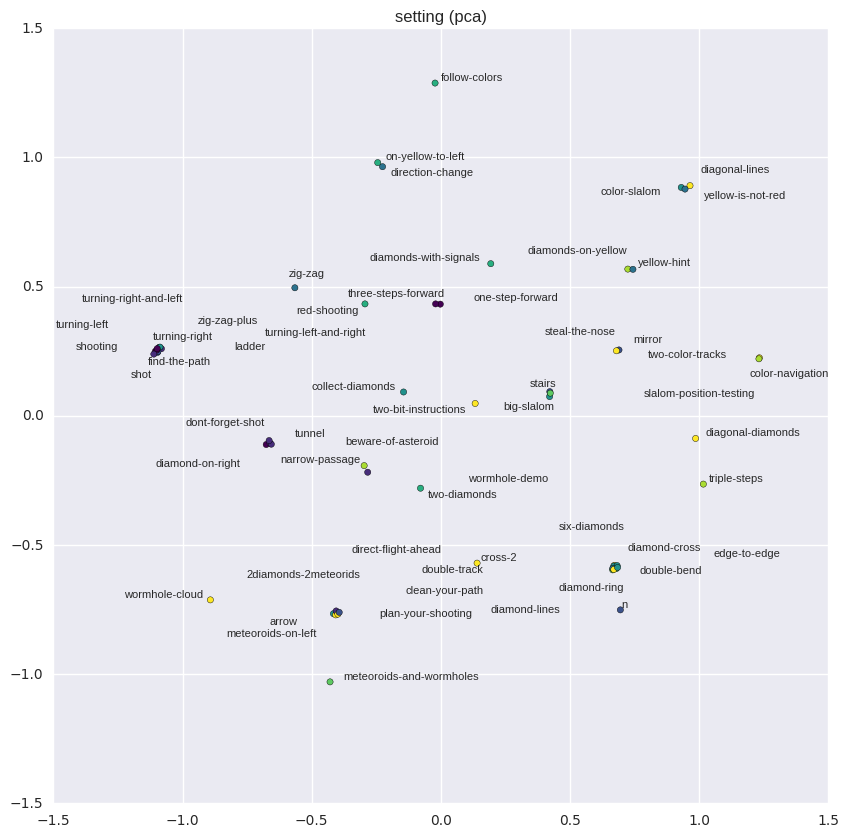

In [218]:
project(setting_features, model='pca', label='setting')

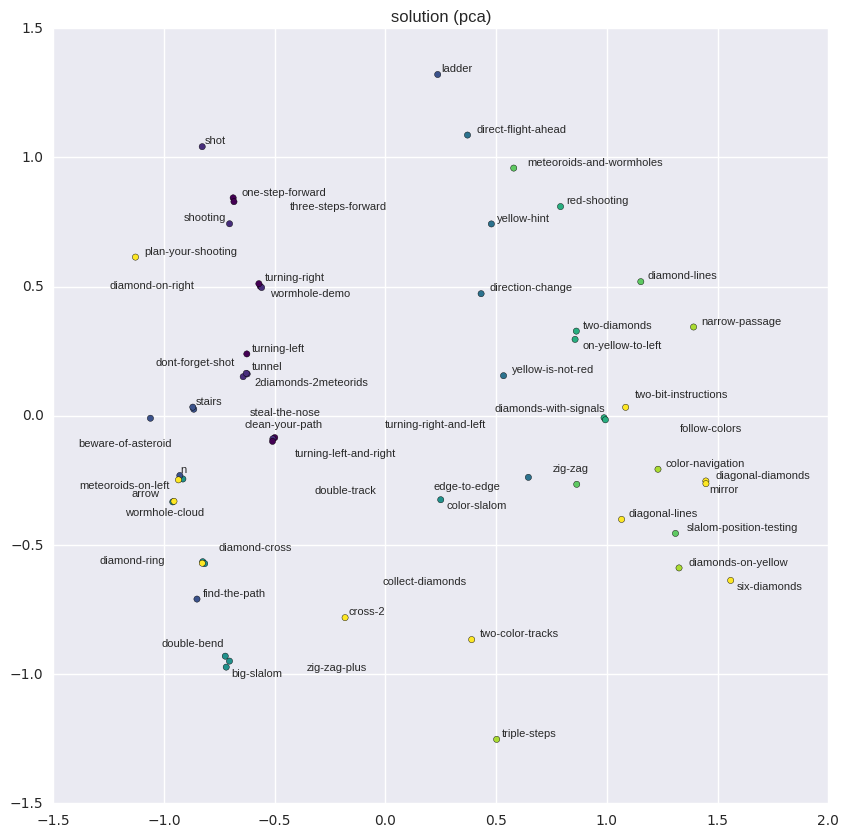

In [219]:
project(solution_features, model='pca', label='solution')

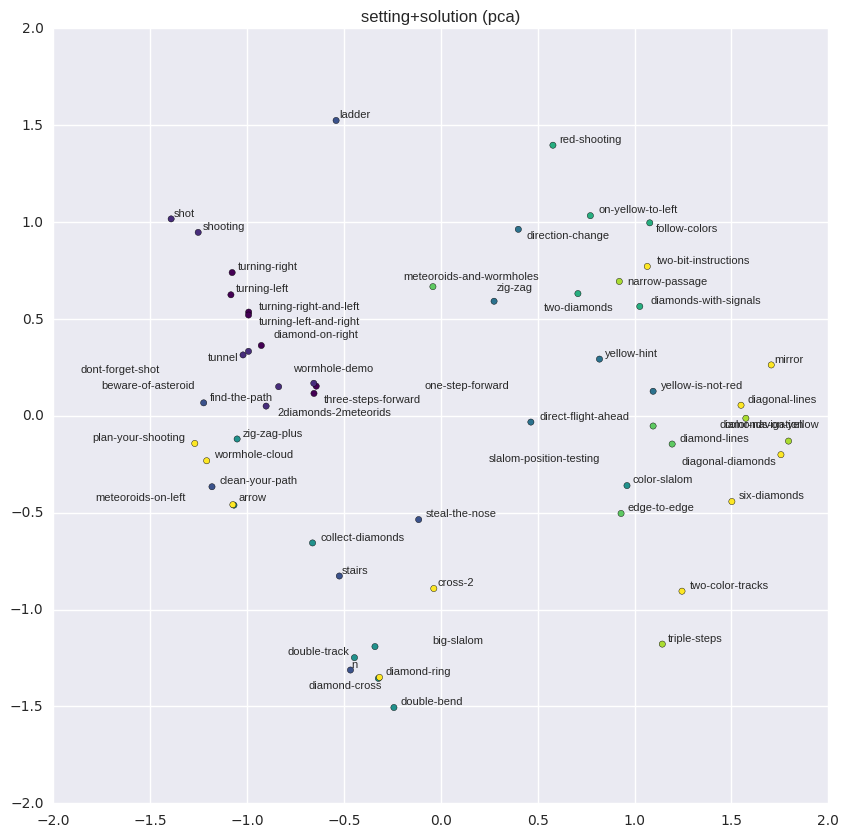

In [220]:
project(all_features, model='pca', label='setting+solution')

# t-SNE

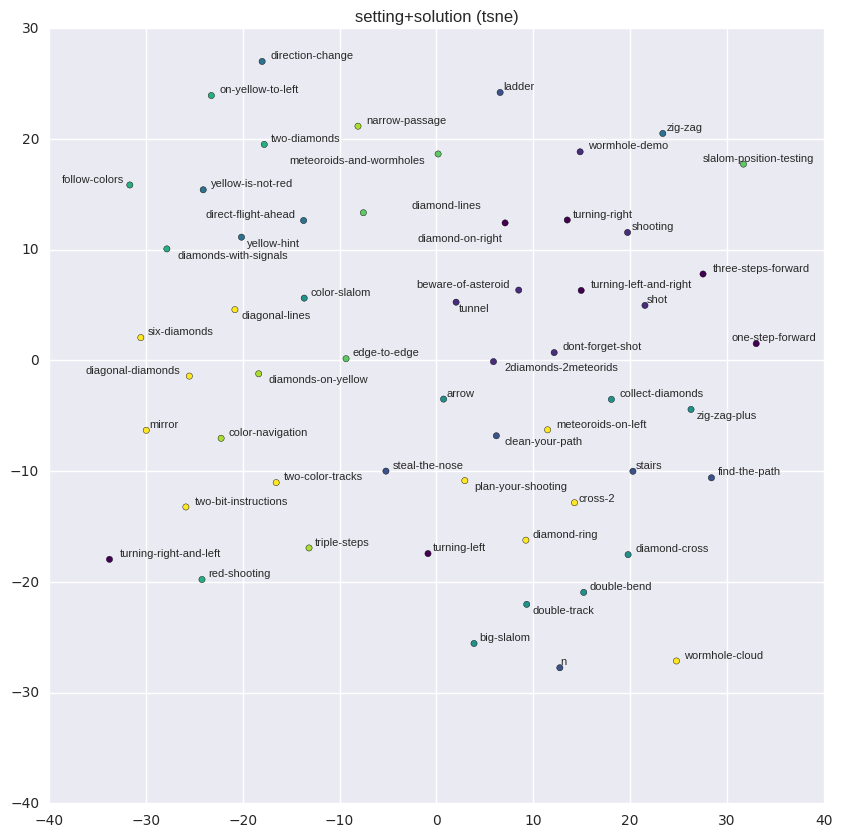

In [221]:
project(all_features, model='tsne', label='setting+solution')